## Circuit cutting with manual cutting

#### Import the necessary Runtime objects, and the WireCutter

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    Options,
)

from circuit_knitting_toolbox.circuit_cutting import WireCutter

#### Create a circuit to cut

This is the example circuit shown in the [cutQC paper](https://dl.acm.org/doi/10.1145/3445814.3446758).

In [10]:
num_qubits = 5

circuit = QuantumCircuit(num_qubits)
for i in range(num_qubits):
    circuit.h(i)
circuit.cx(0, 1)
for i in range(2, num_qubits):
    circuit.t(i)
circuit.cx(0, 2)
circuit.rx(np.pi / 2, 4)
circuit.rx(np.pi / 2, 0)
circuit.rx(np.pi / 2, 1)
circuit.cx(2, 4)
circuit.t(0)
circuit.t(1)
circuit.cx(2, 3)
circuit.ry(np.pi / 2, 4)
for i in range(num_qubits):
    circuit.h(i)

circuit.draw()

┌───┐                ┌─────────┐   ┌───┐   ┌───┐
q_0: ┤ H ├──■───────■─────┤ Rx(π/2) ├───┤ T ├───┤ H ├
     ├───┤┌─┴─┐     │     ├─────────┤   ├───┤   ├───┤
q_1: ┤ H ├┤ X ├─────┼─────┤ Rx(π/2) ├───┤ T ├───┤ H ├
     ├───┤├───┤   ┌─┴─┐   └─────────┘   └───┘   ├───┤
q_2: ┤ H ├┤ T ├───┤ X ├────────■──────────■─────┤ H ├
     ├───┤├───┤   └───┘        │        ┌─┴─┐   ├───┤
q_3: ┤ H ├┤ T ├────────────────┼────────┤ X ├───┤ H ├
     ├───┤├───┤┌─────────┐   ┌─┴─┐   ┌──┴───┴──┐├───┤
q_4: ┤ H ├┤ T ├┤ Rx(π/2) ├───┤ X ├───┤ Ry(π/2) ├┤ H ├
     └───┘└───┘└─────────┘   └───┘   └─────────┘└───┘

#### Set up the runtime service in order to use runtime backends. Otherwise, a local statevector simulator will be used

In [11]:
service = QiskitRuntimeService(
    channel="ibm_quantum",
    token="<YOUR_API_TOKEN>",
)

#### Set up the WireCutter. We will use 2 parallel runtime qasm simulators.
 * If only a circuit is passed to WireCutter, a local statevector simulator will be used to evaluate the subcircuits.

In [12]:
# Set the Sampler and runtime options
options = Options(execution={"shots": 4000})

# Run 2 parallel qasm simulator threads
backend_names = ["ibmq_qasm_simulator"] * 2

# Instantiate a WireCutter and decompose the circuit
cutter = WireCutter(
    circuit, service=service, backend_names=backend_names, options=options
)
# cutter = WireCutter(circuit) # local Estimator

#### Cut the circuit at the specified wire locations

In [5]:
cuts = cutter.decompose(method="manual", subcircuit_vertices=[[0, 1], [2, 3]])

2022-10-19 17:06:15,814	INFO worker.py:1518 -- Started a local Ray instance.


(cut_circuit_wires pid=41629) --------------------
(cut_circuit_wires pid=41629) subcircuit 0
(cut_circuit_wires pid=41629) ρ qubits = 0, O qubits = 1, width = 3, effective = 2, depth = 6, size = 12
(cut_circuit_wires pid=41629)      ┌───┐                     ┌─────────┐┌───┐┌───┐
(cut_circuit_wires pid=41629) q_0: ┤ H ├──■───────────────■──┤ Rx(π/2) ├┤ T ├┤ H ├
(cut_circuit_wires pid=41629)      ├───┤┌─┴─┐┌─────────┐  │  └──┬───┬──┘├───┤└───┘
(cut_circuit_wires pid=41629) q_1: ┤ H ├┤ X ├┤ Rx(π/2) ├──┼─────┤ T ├───┤ H ├─────
(cut_circuit_wires pid=41629)      ├───┤├───┤└─────────┘┌─┴─┐   └───┘   └───┘     
(cut_circuit_wires pid=41629) q_2: ┤ H ├┤ T ├───────────┤ X ├─────────────────────
(cut_circuit_wires pid=41629)      └───┘└───┘           └───┘                     
(cut_circuit_wires pid=41629) subcircuit 1
(cut_circuit_wires pid=41629) ρ qubits = 1, O qubits = 0, width = 3, effective = 3, depth = 6, size = 11
(cut_circuit_wires pid=41629)                                           

#### Evaluate the subcircuits on the backend
 * Two local cores will be used to support each of the parallel backend threads

In [6]:
# Evaluate the subcircuits on backend
subcircuit_instance_probabilities = cutter.evaluate(cuts)

#### Reconstruct the results of the subcircuit experiments into an estimate of the original circuit's full probability distribution

In [7]:
%%capture

reconstructed_probabilities = cutter.reconstruct(
    subcircuit_instance_probabilities, cuts
)

#### If the original circuit is small enough, we can use a statevector simulator to check the results of cutting against the original circuit's true probability distribution

In [8]:
metrics, real_probabilities = cutter.verify(reconstructed_probabilities)
metrics

{'nearest': {'chi2': 0.001992926879479239,
  'Mean Squared Error': 5.404513695240502e-06,
  'Mean Absolute Percentage Error': 7.249425583381597,
  'Cross Entropy': 2.6017056665569562,
  'HOP': 0.9000617812500002},
 'naive': {'chi2': 0.001992926879479239,
  'Mean Squared Error': 5.404513695240472e-06,
  'Mean Absolute Percentage Error': 7.249425583381594,
  'Cross Entropy': 2.6017056665569562,
  'HOP': 0.90006178125}}

#### If we calculated the true probabilities, we can visualize the estimated and true probabilities together and compare

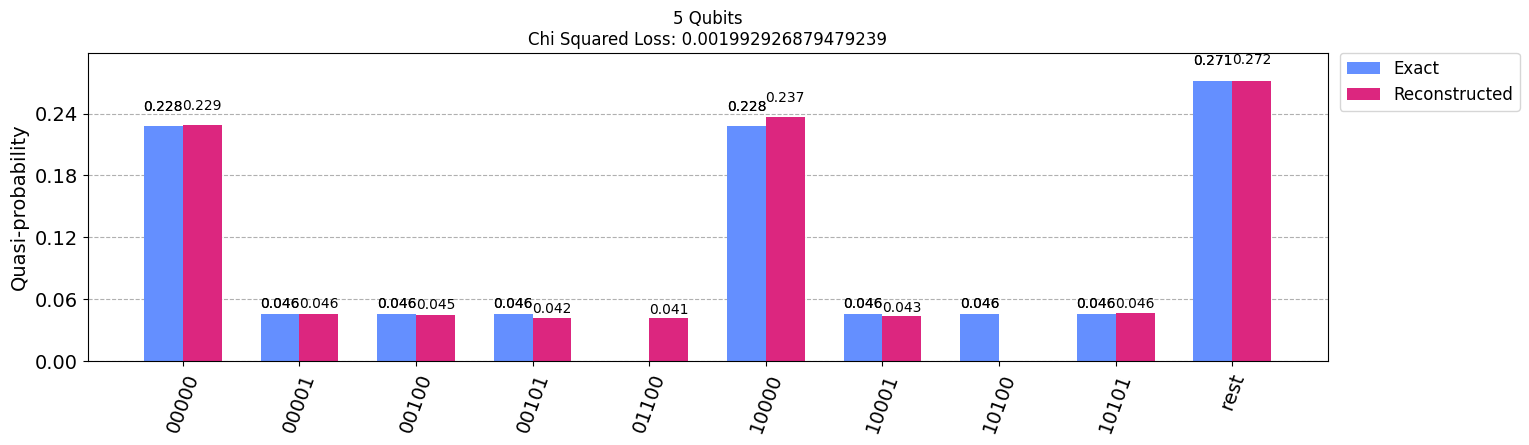

In [13]:
from qiskit.result import ProbDistribution
from qiskit.visualization import plot_histogram

# Get the estimated distribution
reconstructed_distribution = {
    i: prob for i, prob in enumerate(reconstructed_probabilities)
}

# Get the true distribution
true_distribution = {
    i: prob for i, prob in enumerate(real_probabilities)
}

true_dict_bitstring = ProbDistribution(data=true_distribution).binary_probabilities(
    num_bits=num_qubits
)
reconstructed_dict_bitstring = ProbDistribution(
    data=reconstructed_distribution
).binary_probabilities(num_bits=num_qubits)

plot_histogram(
    [true_dict_bitstring, reconstructed_dict_bitstring],
    number_to_keep=8,
    figsize=(16, 4),
    sort="asc",
    legend=["Exact", "Reconstructed"],
    title="{} Qubits\nChi Squared Loss: {}".format(
        num_qubits, metrics["nearest"]["chi2"]
    ),
)